In [83]:
### LOGISTIC REGRESSION CLASSIFIER ###


#glm.fel_assault = glm(Harrassment~.-OffenseDesc-Lat,data = NYPD)
#summary(glm.fel_assault)

#glm.probs=predict(glm.fel_assault,type="response")
#plot(glm.probs)

## Working with DateTime fields

In [86]:
library(plyr)
library(ggplot2)
library(tidyverse)
library(lubridate)
library(tibble)
library(chron)
library(ISLR)
library(tree)

#options(stringsAsFactors = FALSE)

In [7]:
CrimeData = read.csv("NYPD_Complaint_Data_Current__Year_To_Date_.csv")

In [50]:
CD <- data.frame(CrimeData[1:300000,])

CD$ADDR_PCT_CD  <- as.factor(CD$ADDR_PCT_CD)
CD$ReportedDate <- mdy(CD$CMPLNT_TO_DT)

CD$ReportedDate <- as.Date(CD$ReportedDate)

CD$ReportedTime <- CD$CMPLNT_FR_TM
CD$ReportedTime <- chron(times=CD$ReportedTime)

CD$CMPLNT_FR_DT <- NULL
CD$CMPLNT_TO_DT <- NULL

In [51]:
CrimesAgainstBusiness    <- CD[CD$VIC_SEX == 'D',]
CrimesAgainstPeopleOfNYS <- CD[CD$VIC_SEX == 'E',]
CrimesAgainstPersons     <- CD[CD$VIC_SEX == 'M' | CD$VIC_SEX == 'F',]

## Temporary T Dataset for Pre-Processing and Visualization

In [52]:
T <- data.frame(
    OffenseDesc     = CrimesAgainstPersons$OFNS_DESC,
    VicSex          = CrimesAgainstPersons$VIC_SEX,
    VicRace         = CrimesAgainstPersons$VIC_RACE,
    VicAgeGroup     = CrimesAgainstPersons$VIC_AGE_GROUP,
    ReportedDate    = CrimesAgainstPersons$ReportedDate,
    ReportedTime    = CrimesAgainstPersons$ReportedTime,
    Borough         = CrimesAgainstPersons$BORO_NM,
    PremisesType    = CrimesAgainstPersons$PREM_TYP_DESC,
    SusAgeGroup     = CrimesAgainstPersons$SUSP_AGE_GROUP,
    SusRace         = CrimesAgainstPersons$SUSP_RACE,
    SusSex          = CrimesAgainstPersons$SUSP_SEX,
    Latitude        = CrimesAgainstPersons$Latitude,
    Longitude       = CrimesAgainstPersons$Longitude
)

VIC_BizOrg         = ifelse(T$VicSex == "D", 1,0)
VIC_PPLOfNYS       = ifelse(T$VicSex == "E", 1,0)

# Convert Column Types
T$OffenseDesc <- as.factor(T$OffenseDesc)
T$ReportedDate <- as.POSIXlt(T$ReportedDate)

T <- na.omit(T)

# Remove all records older than 2020-01-01
T <- subset(T, T$ReportedDate > ("2019-12-31"))

# Add month column

T$Month = rep(0, nrow(T))

T$Month <- as.POSIXlt(T$ReportedDate)
T$Month <- format(as.Date(T$Month), "%B")

T <- na.omit(T)
T <- T[order(as.Date(T$ReportedDate)),]

# Adding a Week column
T$Week = rep(0, nrow(T))
T$Week <- strftime(T$ReportedDate, format = "%V")

# Adding a  Day Of Week column
T$DayOfWeek = rep(0, nrow(T))
T$DayOfWeek <- strftime(T$ReportedDate, format = "%A")

# Add an hour column
T$ReportedTime <- as.factor(T$ReportedTime)

T$Hour = rep(0, nrow(T))
T$Hour <- format(as.POSIXct(T$ReportedTime,format="%H:%M:%S"),"%H")

T <- na.omit(T)

### NYPD - Processing Ready Dataset

In [67]:
# Create Final Processing Ready Dataset

NYPD <- T

NYPD <- na.omit(NYPD)

NYPD$PremisesType      <- as.factor(NYPD$PremisesType)
NYPD$Borough           <- as.factor(NYPD$Borough)

# Cleaning dataset
NYPD <- na.omit(NYPD)

## Cleaning location data
NYPD <- subset(NYPD, 
               Borough == "BROOKLYN" |
               Borough == "BRONX"|
               Borough == "QUEENS" |
               Borough == "STATEN ISLAND" |
               Borough == "MANHATTAN"
              )

NYPD$Borough <- droplevels(NYPD$Borough)

NYPD <- subset(NYPD,
               PremisesType == "RESIDENCE - APT. HOUSE" |
               PremisesType == "STREET" |
               PremisesType == "RESIDENCE-HOUSE" |
               PremisesType == "RESIDENCE - PUBLIC HOUSING" |
               PremisesType == "OTHER" |
               PremisesType == "GROCERY/BODEGA" |
               PremisesType == "COMMERCIAL BUILDING" |
               PremisesType == "PARK/PLAYGROUND" |
               PremisesType == "RESTAURANT/DINER"|
               PremisesType == "HOTEL/MOTEL" |
               PremisesType == "CHAIN STORE" |
               PremisesType == "HOMELESS SHELTER" |
               PremisesType == "PARKING LOT/GARAGE (PUBLIC" |
               PremisesType == "FAST FOOD" |
               PremisesType == "HOSPITAL" |
               PremisesType == "PARKING LOT/GARAGE (PRIVATE)" |
               PremisesType == "BAR/NIGHT CLUB" |
               PremisesType == "DEPARTMENT STORE" |
               PremisesType == "PUBLIC SCHOOL" |
               PremisesType == "BANK" |
               PremisesType == "BUS (NYC TRANSIT)" |
               PremisesType == "PUBLIC BUILDING" |
               PremisesType == "FOOD SUPERMARKET" |
               PremisesType == "DRUG STORE" |
               PremisesType == "HIGHWAY/PARKWAY" |
               PremisesType == "GAS STATION" |
               PremisesType == "DRY CLEANER/LAUNDRY" |
               PremisesType == "DOCTOR/DENTIST OFFICE"               
              )

NYPD$PremisesType <- droplevels(NYPD$PremisesType)

## CLEANING VICTIM DATA
NYPD <- subset(NYPD, 
               VicAgeGroup == "<18" |
               VicAgeGroup == "18-24" |
               VicAgeGroup == "25-44" |
               VicAgeGroup == "45-64" |
               VicAgeGroup == "65+" |
               VicAgeGroup == "UNKNOWN"
              )

NYPD$VicAgeGroup <- droplevels(NYPD$VicAgeGroup)

NYPD <- subset(NYPD, VicSex == "M" | VicSex == "F")
NYPD$VicSex <-droplevels(NYPD$VicSex)

NYPD <- subset(NYPD,
               VicRace == "AMERICAN INDIAN/ALASKAN NATIVE" |
               VicRace == "ASIAN / PACIFIC ISLANDER" |
               VicRace == "BLACK" |
               VicRace == "BLACK HISPANIC" |
               VicRace == "WHITE HISPANIC" |
               VicRace == "WHITE" |
               VicRace == "UNKNOWN"
              )

NYPD$VicRace <- droplevels(NYPD$VicRace)

## CLEANING SUSPECT DATA
NYPD <- subset(NYPD, 
               Borough == "BROOKLYN" |
               Borough == "BRONX"|
               Borough == "QUEENS" |
               Borough == "STATEN ISLAND" |
               Borough == "MANHATTAN"
              )

NYPD$Borough <- droplevels(NYPD$Borough)

## CLEANING SUSPECT DATA
NYPD <- subset(NYPD, 
               SusAgeGroup == "<18" |
               SusAgeGroup == "18-24" |
               SusAgeGroup == "25-44" |
               SusAgeGroup == "45-64" |
               SusAgeGroup == "65+"
              )

NYPD$SusAgeGroup <- droplevels(NYPD$SusAgeGroup)

NYPD <- subset(NYPD, SusSex == "M" | SusSex == "F")
NYPD$SusSex <-droplevels(NYPD$SusSex)

NYPD <- subset(NYPD,
               SusRace == "AMERICAN INDIAN/ALASKAN NATIVE" |
               SusRace == "ASIAN / PACIFIC ISLANDER" |
               SusRace == "BLACK" |
               SusRace == "BLACK HISPANIC" |
               SusRace == "WHITE HISPANIC" |
               SusRace == "WHITE" |
               SusRace == "UNKNOWN"
              )
NYPD$SusRace <- droplevels(NYPD$SusRace)


NYPD <- subset(NYPD, 
               OffenseDesc == "HARRASSMENT 2" |
               #OffenseDesc == "FELONY ASSAULT"|
               OffenseDesc == "CRIMINAL MISCHIEF & RELATED OF"|
               OffenseDesc == "GRAND LARCENY"|
               OffenseDesc == "OFF. AGNST PUB ORD SENSBLTY &"|
               OffenseDesc == "ROBBERY"|
               OffenseDesc == "VEHICLE AND TRAFFIC LAWS"|
               OffenseDesc == "SEX CRIMES"|
               OffenseDesc == "OFFENSES AGAINST PUBLIC ADMINI"|
               OffenseDesc == "THEFT-FRAUD"|
               OffenseDesc == "RAPE"|
               OffenseDesc == "CRIMINAL TRESPASS"|
               OffenseDesc == "FRAUDS"|
               OffenseDesc == "UNAUTHORIZED USE OF A VEHICLE"|
               OffenseDesc == "ADMINISTRATIVE CODE"
              )

NYPD$Hour       <- as.factor(NYPD$Hour)
NYPD$Month      <- as.factor(NYPD$Month)
NYPD$Week       <- as.numeric(NYPD$Week)
NYPD$DayOfWeek  <- as.factor(NYPD$DayOfWeek)

NYPD$Harrassment   = ifelse(NYPD$OffenseDesc == "HARRASSMENT 2", TRUE, FALSE)
NYPD$Harrassment <- as.factor(NYPD$Harrassment)

NYPD$OffenseDesc <- droplevels(NYPD$OffenseDesc)

NYPD           <- as.data.frame(NYPD)
rownames(NYPD) <- NULL


NYPD$ReportedDate <- NULL
NYPD$ReportedTime <- NULL



# Cleaning dataset
NYPD <- na.omit(NYPD)


## Creating Training and Validation Datasets

In [101]:
## 75% of the sample size
smp_size <- floor(0.75 * nrow(NYPD))

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(NYPD)), size = smp_size, replace = TRUE)

train <- NYPD[train_ind, ]
test  <- NYPD[-train_ind, ]

rownames(train) <- NULL
rownames(test) <- NULL

dim(train)
dim(test)

[1] 33099    16

[1] 20897    16

In [100]:
#summary(NYPD)
#sapply(NYPD, class)
#sapply(test, class)

## Decision Tree Classifier


Classification tree:
tree(formula = Harrassment ~ . - OffenseDesc - Longitude - Latitude, 
    data = train)
Variables actually used in tree construction:
[1] "SusAgeGroup"  "PremisesType"
Number of terminal nodes:  3 
Residual mean deviance:  1.337 = 44240 / 33100 
Misclassification error rate: 0.4193 = 13879 / 33099 

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

1) root 33099 45740 TRUE ( 0.4668 0.5332 )  
  2) SusAgeGroup: <18,18-24,25-44 25386 35170 FALSE ( 0.5145 0.4855 )  
    4) PremisesType: DEPARTMENT STORE,GAS STATION,HIGHWAY/PARKWAY,PARK/PLAYGROUND,PARKING LOT/GARAGE (PRIVATE),STREET 5338  6930 FALSE ( 0.6472 0.3528 ) *
    5) PremisesType: BANK,BAR/NIGHT CLUB,BUS (NYC TRANSIT),CHAIN STORE,COMMERCIAL BUILDING,DOCTOR/DENTIST OFFICE,DRUG STORE,DRY CLEANER/LAUNDRY,FAST FOOD,FOOD SUPERMARKET,GROCERY/BODEGA,HOMELESS SHELTER,HOSPITAL,HOTEL/MOTEL,OTHER,PUBLIC BUILDING,PUBLIC SCHOOL,RESIDENCE-HOUSE,RESIDENCE - APT. HOUSE,RESIDENCE - PUBLIC HOUSING,RESTAURANT/DINER 20048 27760 TRUE ( 0.4792 0.5208 ) *
  3) SusAgeGroup: 45-64,65+ 7713  9549 TRUE ( 0.3099 0.6901 ) *

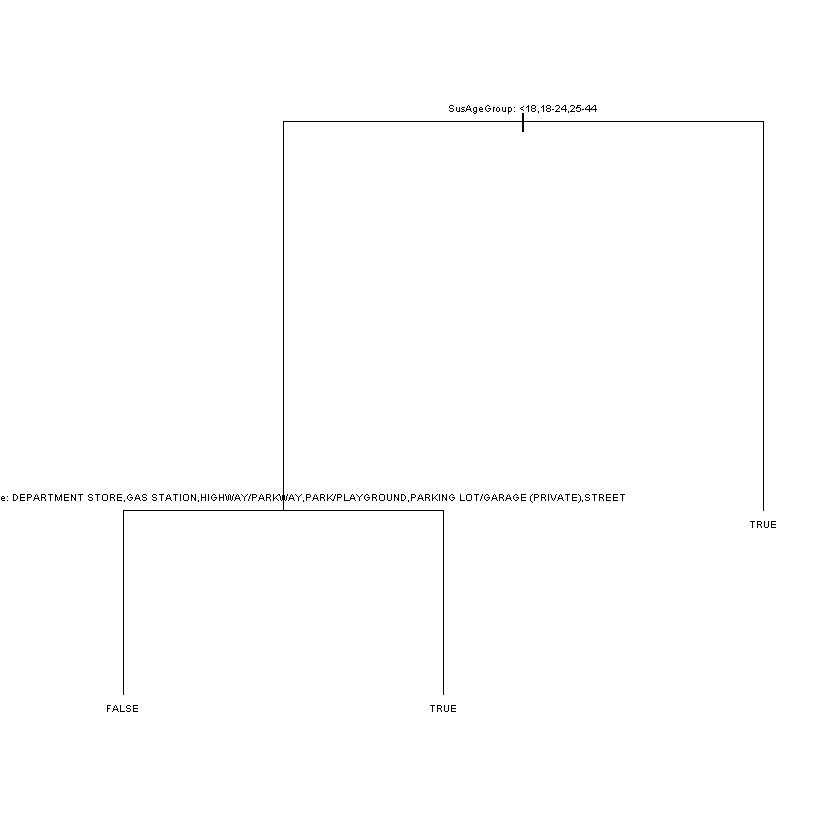

In [139]:
NYPD$Harrassment <- as.factor(NYPD$Harrassment)

#attach(NYPD)

tree.harrassment = tree(Harrassment~.-OffenseDesc-Longitude-Latitude, data = train)
summary(tree.harrassment)

tree.harrassment

plot(tree.harrassment)
text(tree.harrassment, pretty=0, cex = 0.5)

In [140]:
# make predictions using the 'tree.harrassment' model we learned
tree.pred = predict(tree.harrassment, test, type="class")

with(test, table(tree.pred, Harrassment))

         Harrassment
tree.pred FALSE TRUE
    FALSE  2162 1215
    TRUE   7609 9911

In [141]:
# Model Accuracy rate is 57%
12073 / 20897

[1] 0.5777384

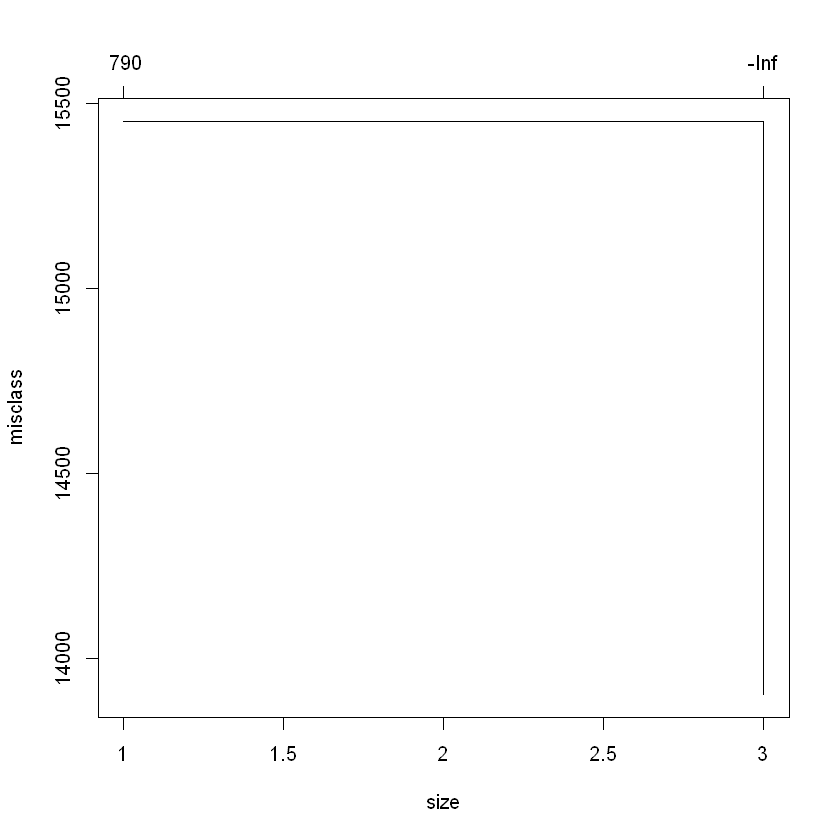

In [145]:
# Determining optimal tree depth

cv.harrassment = cv.tree(tree.harrassment, FUN = prune.misclass)
#cv.harrassment

plot(cv.harrassment)

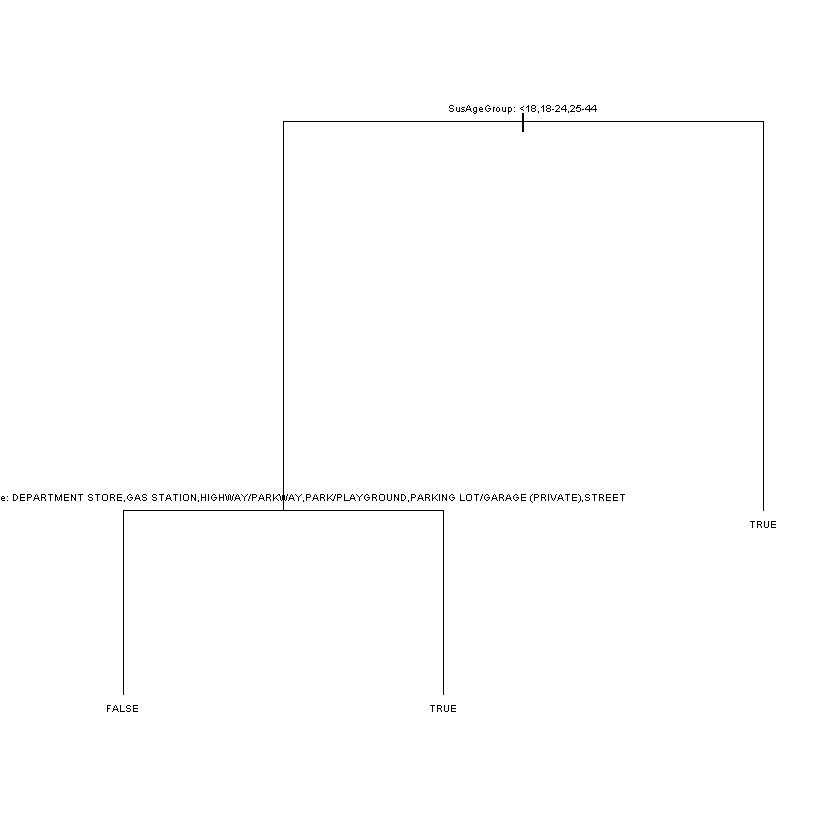

In [147]:
prune.harrassment = prune.misclass(tree.harrassment, best = 3)
plot(prune.harrassment)
text(prune.harrassment, pretty=0, cex = 0.5)

In [150]:
## Attempting to Improve Decision Tree Classifier Performance Using Boosting

,var,rel.inf
Hour,Hour,27.046739
PremisesType,PremisesType,21.525922
SusAgeGroup,SusAgeGroup,8.981165
Longitude,Longitude,7.146539
Latitude,Latitude,7.049003
Month,Month,5.739357
VicAgeGroup,VicAgeGroup,5.737059
SusSex,SusSex,3.871493
DayOfWeek,DayOfWeek,3.431527
VicRace,VicRace,2.616867


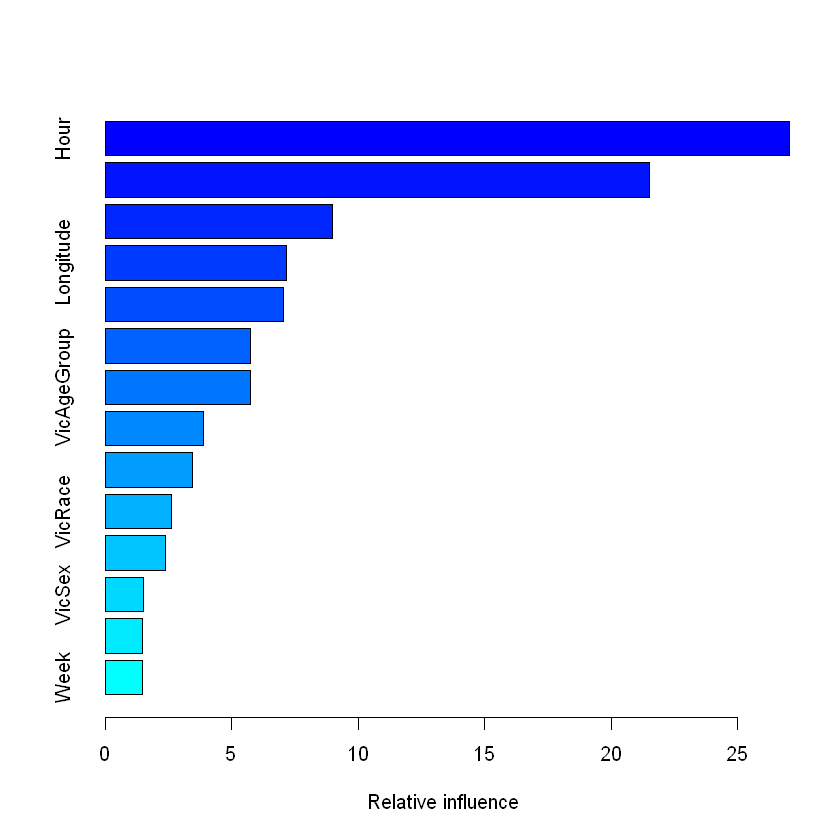

In [154]:
library(gbm)

#boost.boston = gbm(Harrassment~.-OffenseDesc, data = train, distribution = "gaussian", n.trees = 10000, shrinkage = 0.01, interaction.depth = 3)
summary(boost.boston)

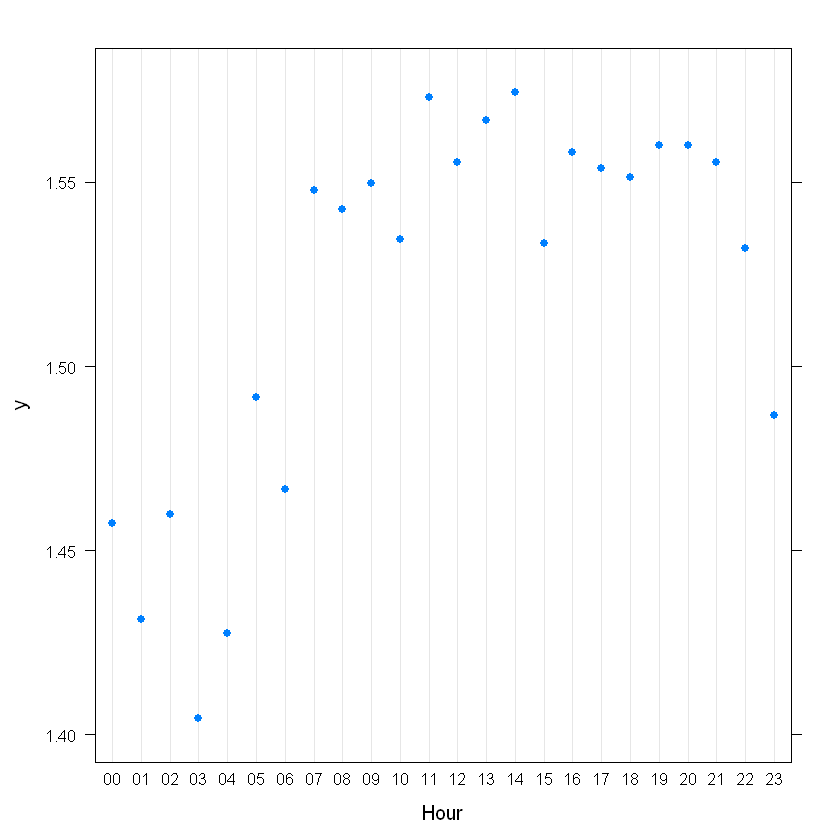

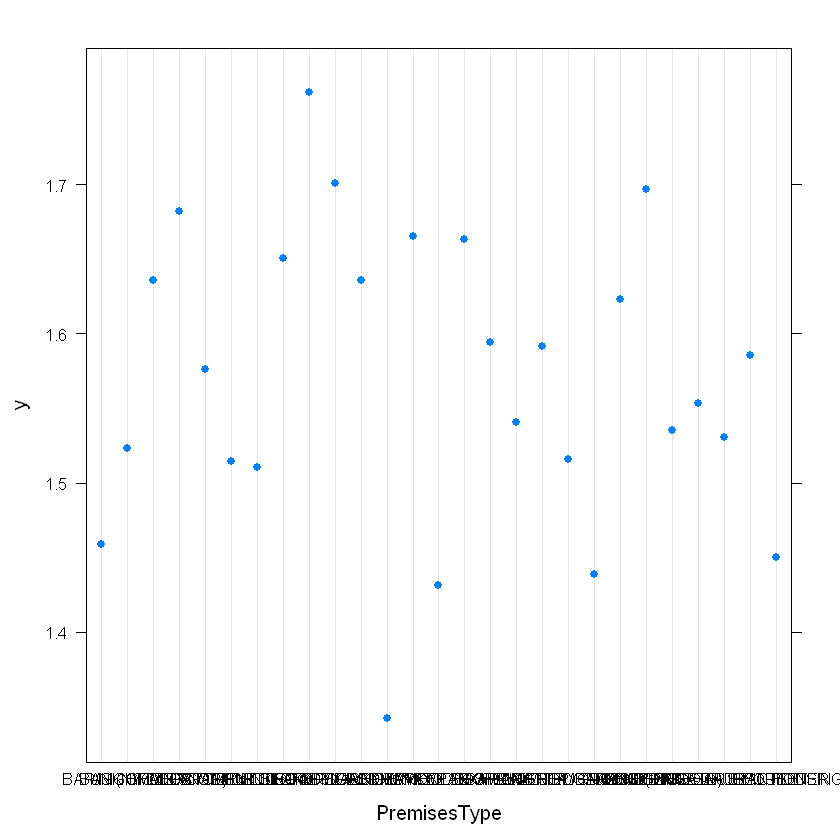

In [163]:
plot(boost.boston,i="Hour")
plot(boost.boston,i="PremisesType")

In [164]:
n.trees = seq(from = 100, to = 10000, by = 100)
predmat = predict(boost.boston, newdata = test, n.trees = n.trees)
dim(predmat)

[1] 20897   100

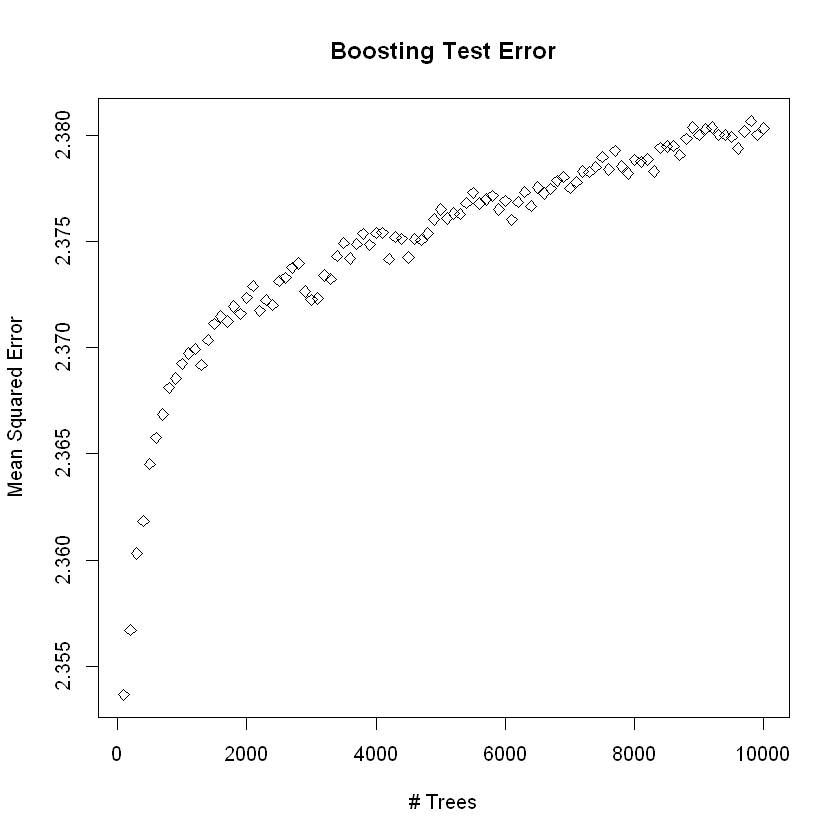

In [171]:
boost.err = with(test, apply( (predmat)^2, 2, mean) )
plot(n.trees, boost.err, pch = 23, ylab = "Mean Squared Error", xlab = "# Trees", main = "Boosting Test Error")

In [173]:
# Test error goes up from 100 trees

In [174]:
predmat = predict(boost.boston, newdata = test, n.trees = 100)

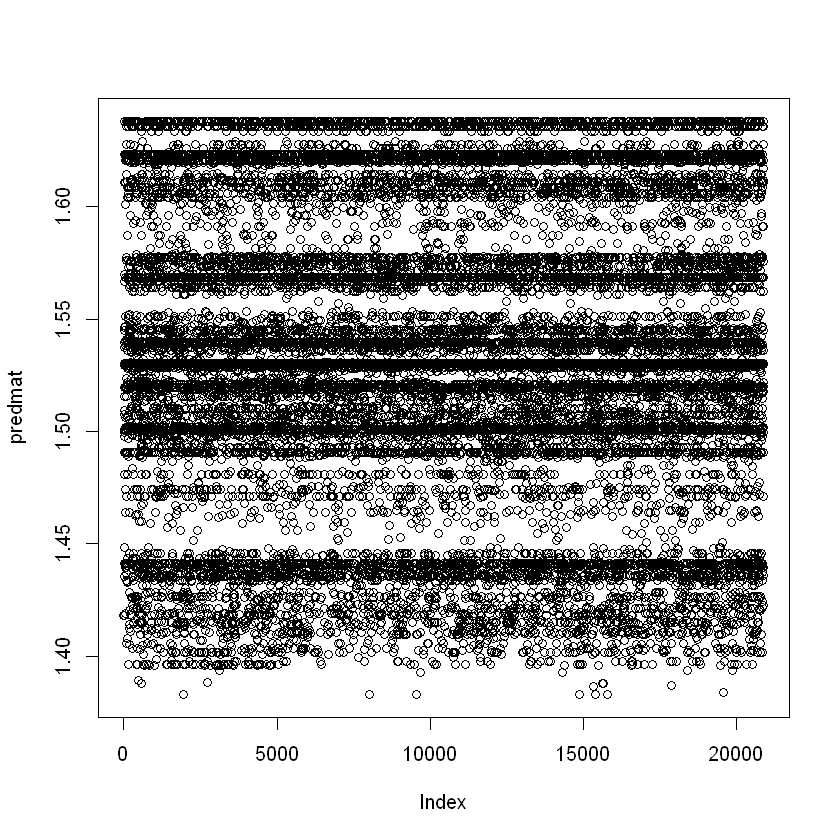

,var,rel.inf
SusAgeGroup,SusAgeGroup,43.124290
PremisesType,PremisesType,21.006532
SusSex,SusSex,15.880448
VicAgeGroup,VicAgeGroup,13.851579
Hour,Hour,5.933267
VicSex,VicSex,0.203884
VicRace,VicRace,0.000000
Borough,Borough,0.000000
SusRace,SusRace,0.000000
Latitude,Latitude,0.000000


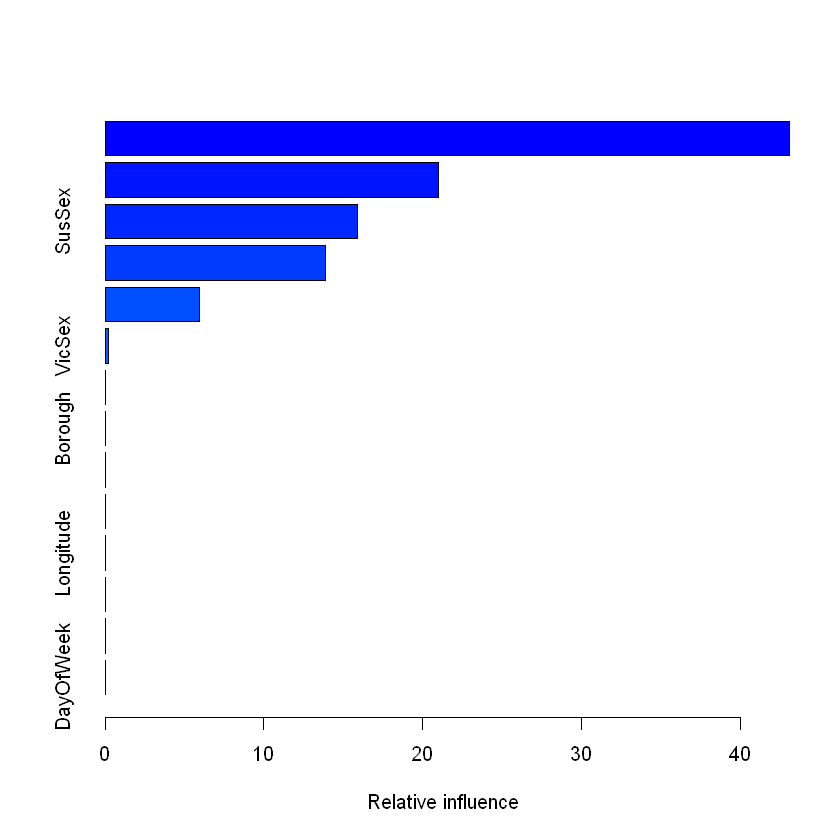

In [178]:
boost.harrassment = gbm(Harrassment~.-OffenseDesc, data = train, distribution = "gaussian", n.trees = 100, shrinkage = 0.01, interaction.depth = 3)
summary(boost.harrassment)

In [189]:
## Given that Boosted decision trees, produced the same splitting criteria, no further accuracy improvement is possible
# using decision trees